# Случайные процессы. Практическое задание 6

* Дедлайн **26 ноября 23:59** (13 дней на выполнение).
* Внимательно прочтите правила оформления. Задания, оформленные не по правилам, могут быть проигнорированы.
* В коде могут встречаться пропуски, которые обычно обозначаются так: <пояснение>

--------------

Для выполнения задания потребуются следующие библиотеки: hmmlearn, librosa. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install hmmlearn

sudo pip3 install librosa

В случае возникновения проблем пишите на почту.

--------------

## 1. Скрытые марковские модели

Теоретический материал по скрытым марковским моделям будет рассказан на лекции 14 ноября (в день выдачи задания). Реализация методов является полезной, но технически сложной, поэтому мы воспользуемся готовой реализацией `hmmlearn`. Документация http://hmmlearn.readthedocs.io/. Интерфейс данной библиотеки максимально близок к библиотеке `scikit-learn`, которая в следующем семестре у вас будет основной библиотекой в курсе машинного обучения. 

Все необходимые комментарии по интерфейсу библиотеки `hmmlearn` приведены в коде далее. Следуйте указаниям.

In [1]:
import numpy as np
import sys
from hmmlearn import hmm

import matplotlib.pyplot as plt
%matplotlib inline

Зададим некоторую скрытую марковскую модель

In [107]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, что каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]]])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

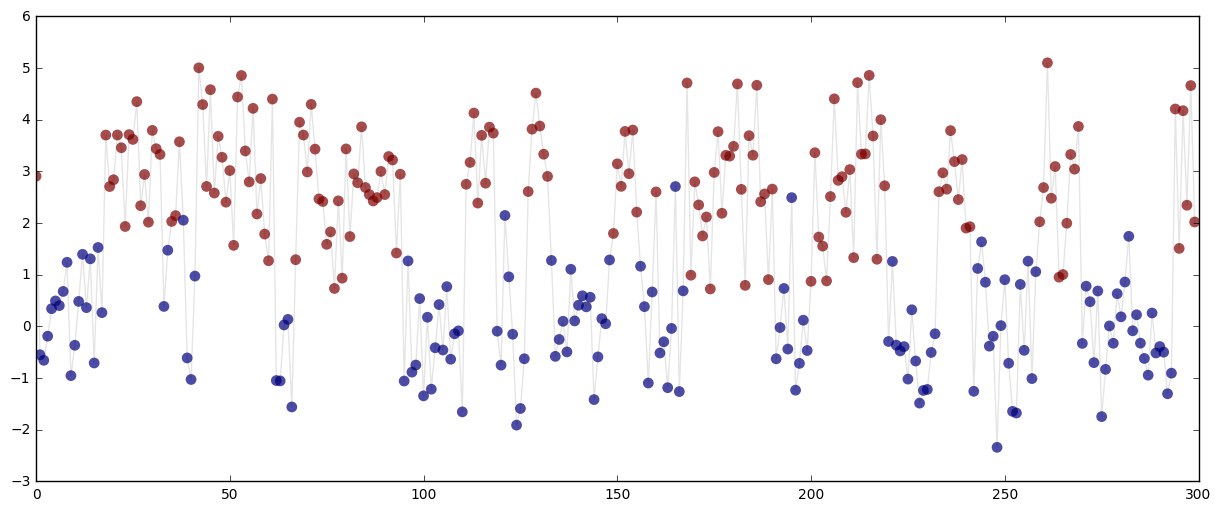

In [109]:
import warnings
warnings.filterwarnings('ignore')

size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [5]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния которых получилась неправильно.

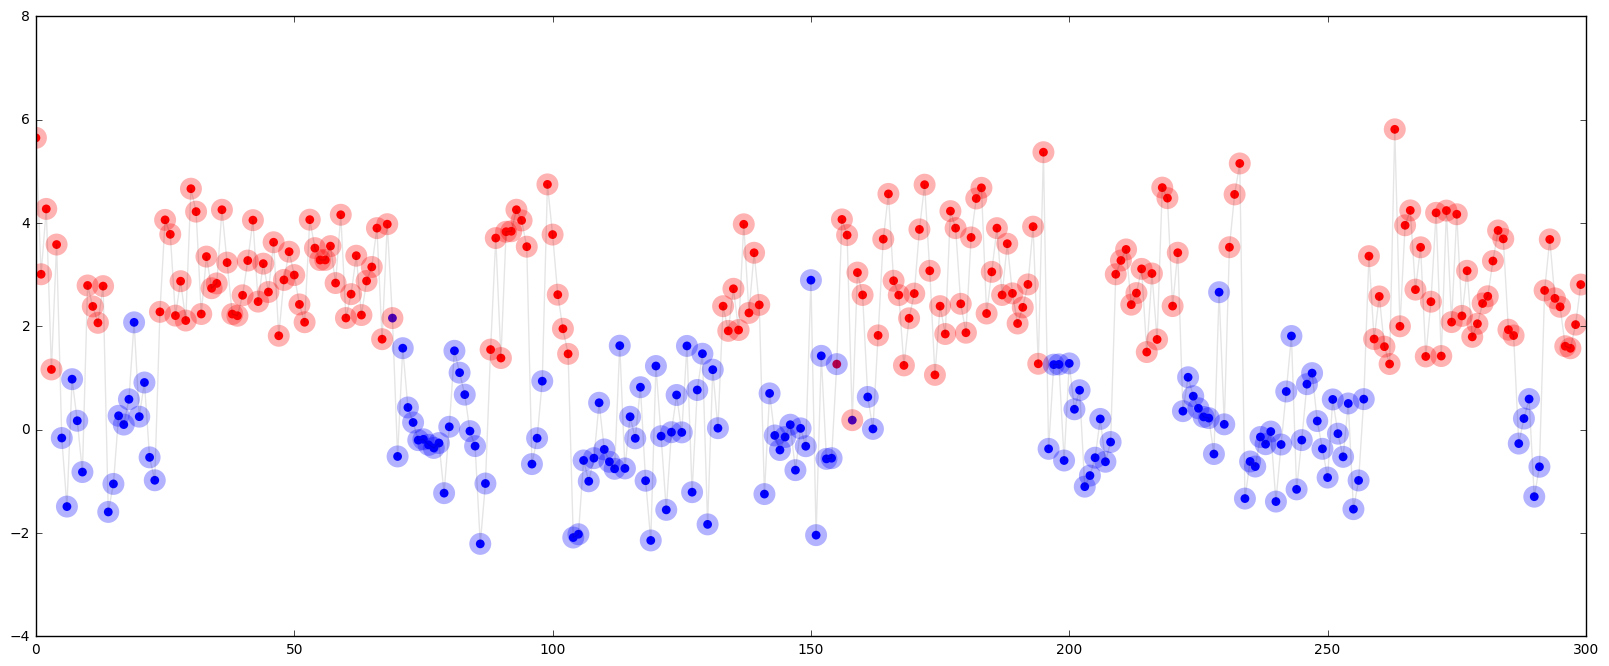

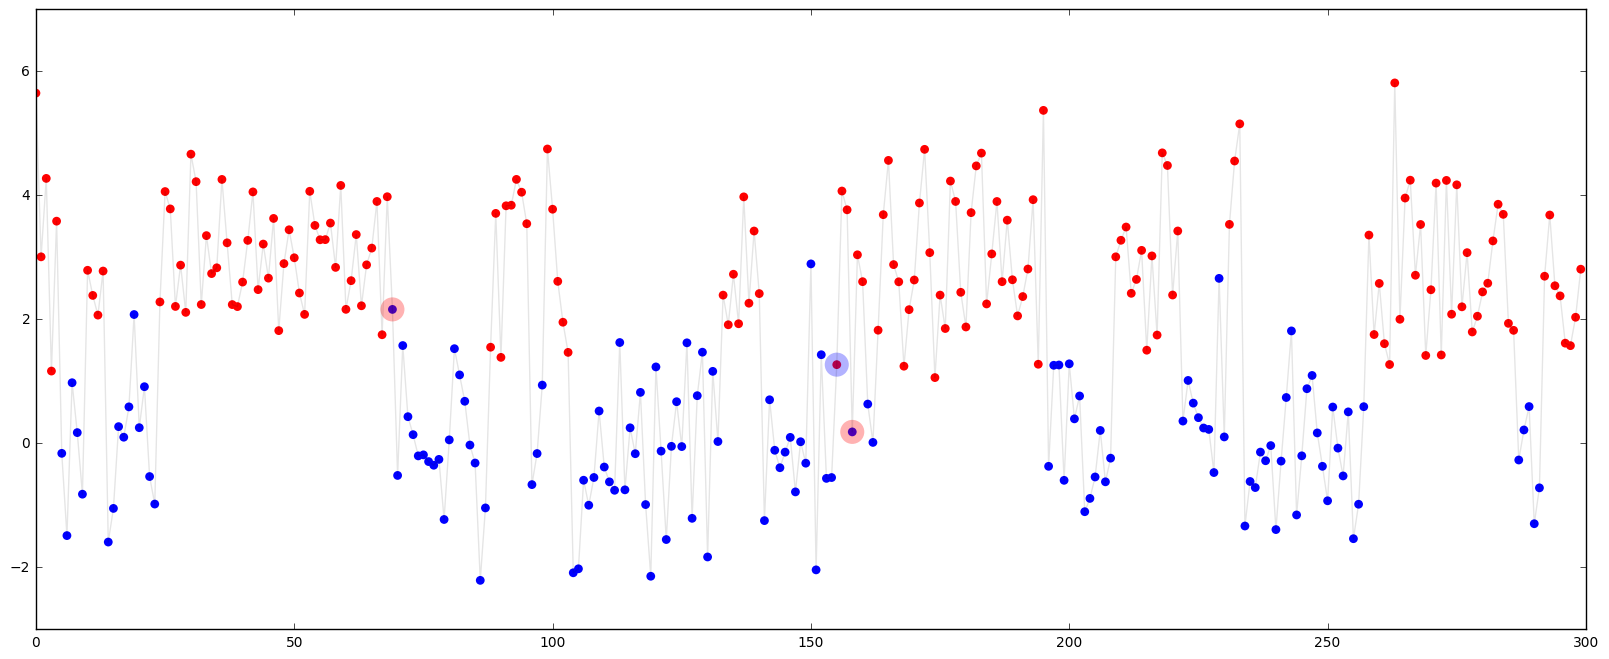

In [6]:
colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Как понять, что EM-алгоритм сошелся? Для этого нужно посчитать значение некоторого функционала, который является чересчур громоздким. Поэтому мы всего лишь посмотрим на его значения. Данная функциональность в библиотеке реализованна слишком странно. Следуйте коммантариям.

In [7]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

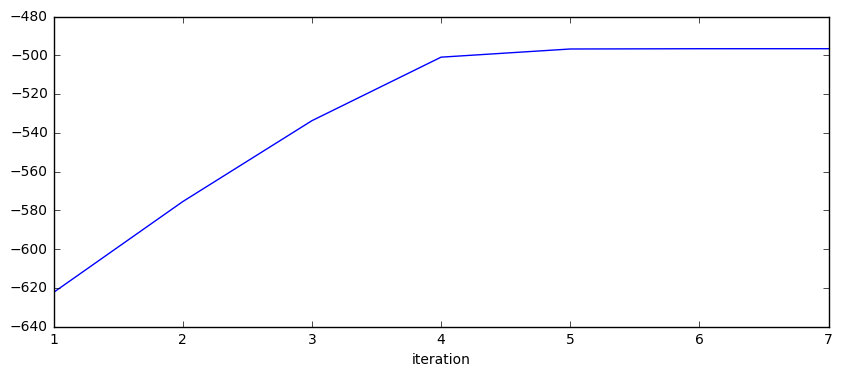

In [8]:

values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.show()

Выполните те же операции для следующих двух случаев

* скрытая марковская цепь имеет три скрытых состояния;

* распределение $Y_j$ при условии $X_j$ является двумерным гауссовским.

### a) Цепь с тремя скрытыми состояниями

Добавим еще одно состояние. Для сравнения рассмотрим 2 варианта скрытых марковских цепей: в первом случае области наиболее вероянтых возможных значений, генерируемые разными состояниями не будут пересекаться ( разница между средними больше суммы дисперсий) - в этом случае восстановить скрытое состояние проще, а во втором эти области будут накладываться друг на друга. Так же в первой модели в двух из трех состояниях вероятность уйти из состояний будет больше, чем вероятность остаться в них, а во второй модели вероятность остаться в каком-либо из состояний будет большой.

In [247]:
# "разреженная" модель
model_1 = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

model_1.startprob_ = np.array([0.5, 0.4, 0.1])
model_1.transmat_ = np.array([[0.7, 0.29 , 0.01],
                            [0.01, 0.49, 0.5],
                            [0.35, 0.35, 0.3]])
model_1.means_ = np.array([[0.0], [3.0], [-5.0]])
model_1.covars_ = np.array([[[1]], [[1]], [[0.5]]])

#модель "с пересечениями"
model_2 = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

model_2.startprob_ = np.array([0.5, 0.4, 0.1])
model_2.transmat_ = np.array([[0.8, 0.1 , 0.1],
                            [0.07, 0.9, 0.03],
                            [0.05, 0.05, 0.9]])
model_2.means_ = np.array([[0.0], [3.0], [-2.0]])
model_2.covars_ = np.array([[[2]], [[2]], [[5]]])

Генерация последовательностей

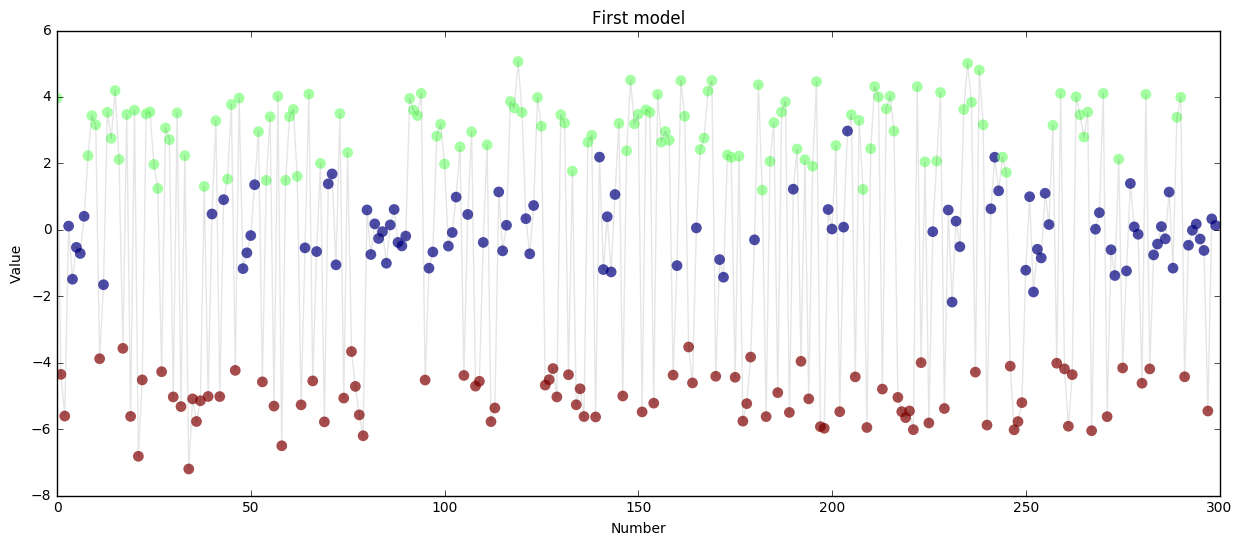

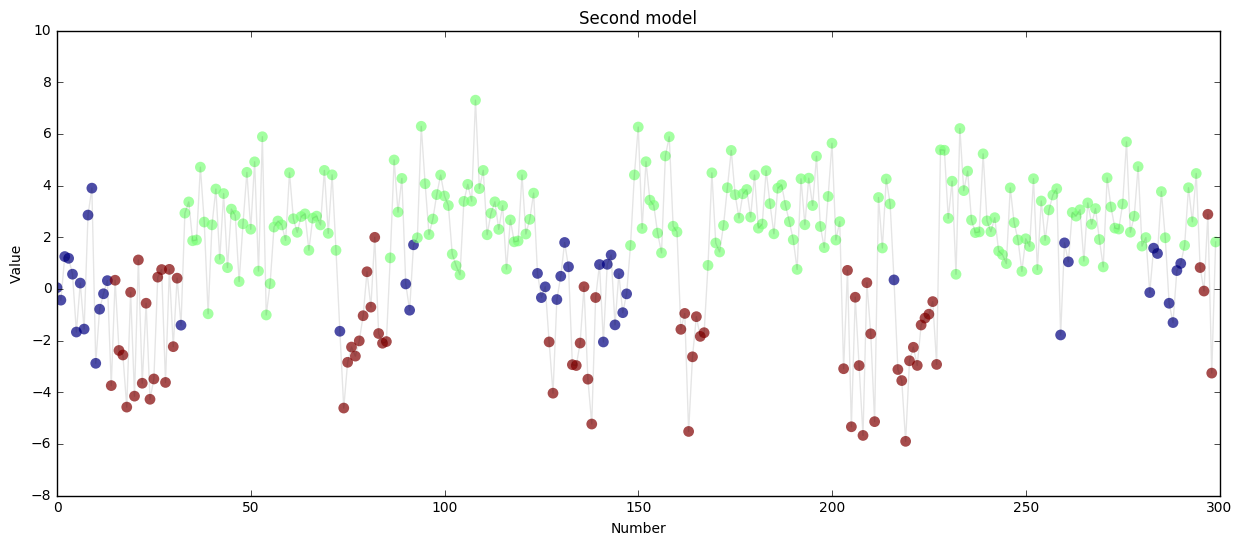

In [251]:
import warnings
warnings.filterwarnings('ignore')

size = 300
Y_1, X_1 = model_1.sample(size)   # Y наблюдаемы, X скрытые
Y_2, X_2 = model_2.sample(size)

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y_1[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y_1[:, 0], c=np.array(X_1), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.title("First model")
plt.ylabel("Value")
plt.xlabel("Number")
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y_2[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y_2[:, 0], c=np.array(X_2), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.title("Second model")
plt.ylabel("Value")
plt.xlabel("Number")
plt.show()

Итак, на первом графике видно, что после точки красного или зеленого цвета почти всегда следует точка другого цвета, можно наблюдать только идущие подряд синие точки, как и было задано. Во второй модели нет отдельно стоящих точек какого-то цвета, что логично ожидать, тк вероятность не поменять цвет >=0.8. Так же на первом графике очень легко даже визуально разграничить данные, тогда как на втором это сделать значительно сложнее. Только в случае если точка находится выше 3 или ниже -3 это можно определить почти однозначно, в средней же области встречаются много точек разных цветов и разграничить их весьма проблемно. Посмотрим, как будет радотатьт алгоритм.

Обучение моделей

In [284]:
remodel_1 = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, algorithm='viterbi')
remodel_1.fit(Y_1)  
X_predicted_1 = remodel_1.predict(Y_1)

remodel_2 = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, algorithm='viterbi')
remodel_2.fit(Y_1)  
X_predicted_2 = remodel_2.predict(Y_1)

Построение графиков
На первом графике буду отмечать только те точки, состояние которых было предсказано неправильно ( как в примере)

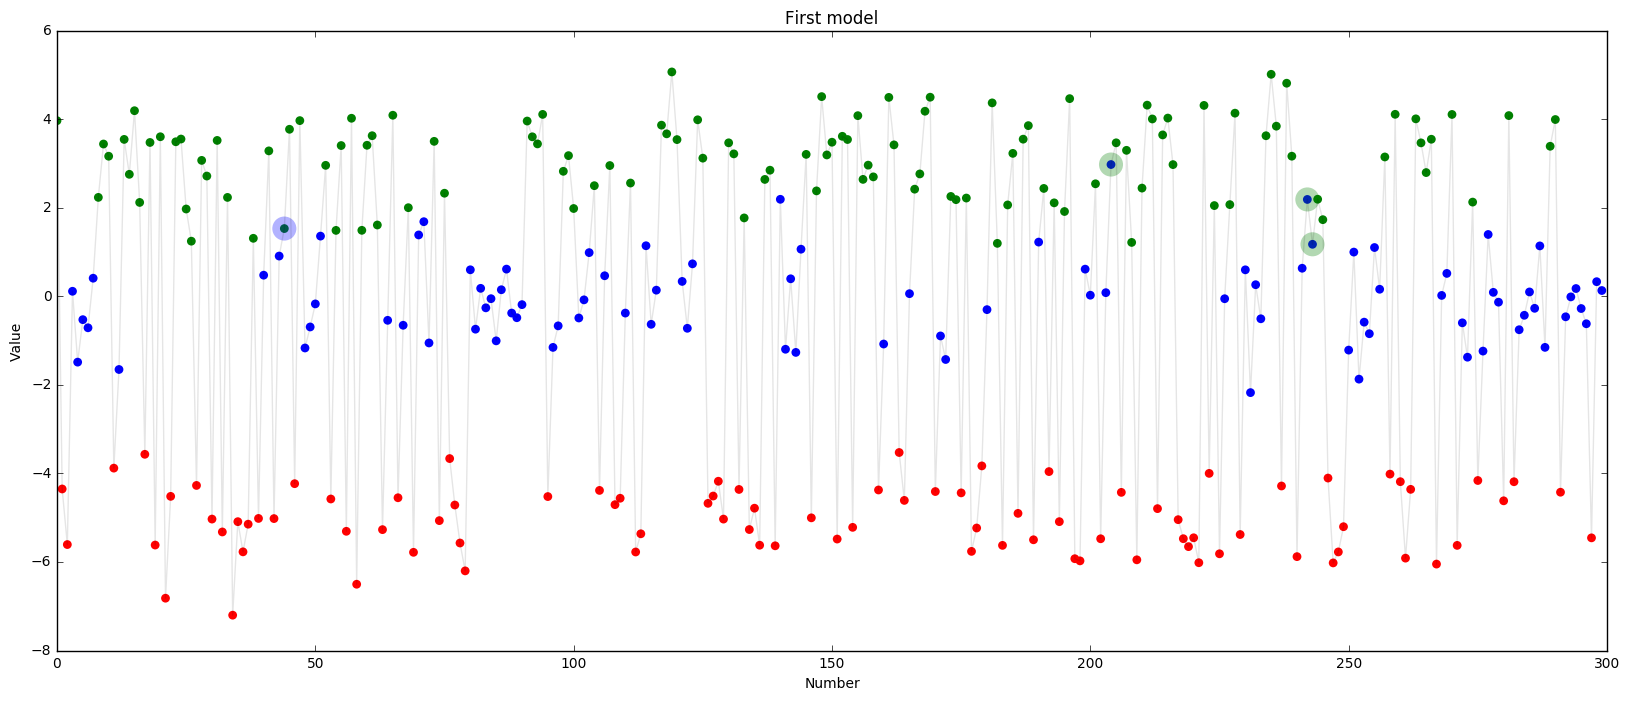

In [270]:
colors = np.array(['blue', 'green', 'red'])

# Состояния определяются с точностью до их перестановки.
# Меняем местами состояния, если нужно (первое и последнее - как показывает практика)
if (X != X_predicted).sum() > size / 2:
    X_predicted_1 = 2 - X_predicted_1

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y_1[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y_1[:, 0], c=colors[np.array(X_1)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X_1 != X_predicted_1], Y_1[:, 0][X_1 != X_predicted_1], 
            c=colors[np.array(X_predicted_1)[X_1 != X_predicted_1]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.title("First model")
plt.ylabel("Value")
plt.xlabel("Number")
plt.show()

Модель почти не ошибается

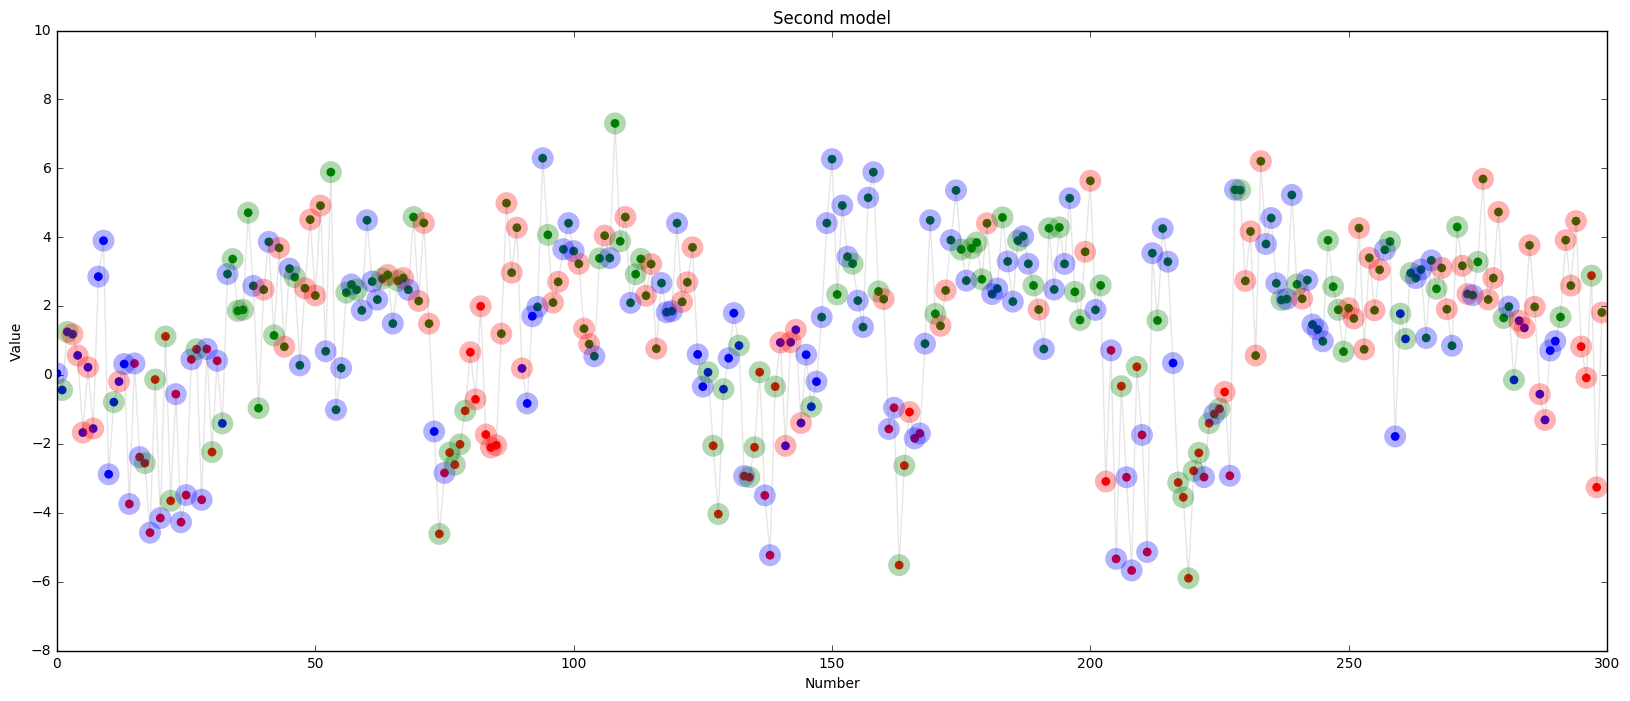

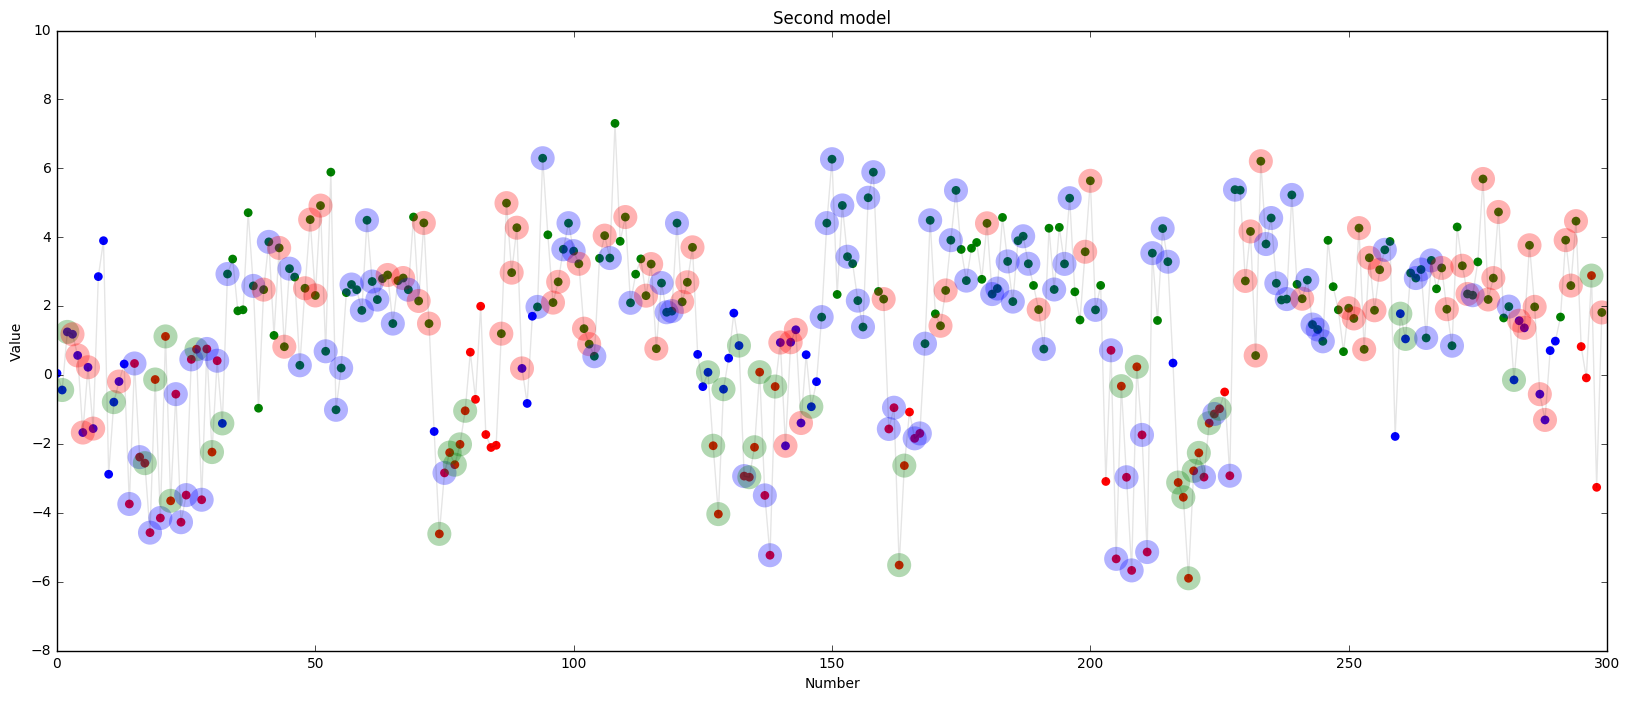

In [285]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y_2[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y_2[:, 0], c=colors[np.array(X_2)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y_2[:, 0], c=colors[np.array(X_predicted_2)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.title("Second model")
plt.ylabel("Value")
plt.xlabel("Number")
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y_2[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y_2[:, 0], c=colors[np.array(X_2)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X_2 != X_predicted_2], Y_2[:, 0][X_2 != X_predicted_2], 
            c=colors[np.array(X_predicted_2)[X_2 != X_predicted_2]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.title("Second model")
plt.ylabel("Value")
plt.xlabel("Number")
plt.show()

Здесь все настолько перемешано, что даже изменение порядка цветов ничего не улучшит. Модель плохо предсказывает состояния.

Посмотрим на ошибки моделей

In [303]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y_1)  
X_predicted = remodel.predict(Y_1)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

values_1 = np.loadtxt('./est_values.txt')

In [304]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y_2)  
X_predicted = remodel.predict(Y_2)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

values_2 = np.loadtxt('./est_values.txt')


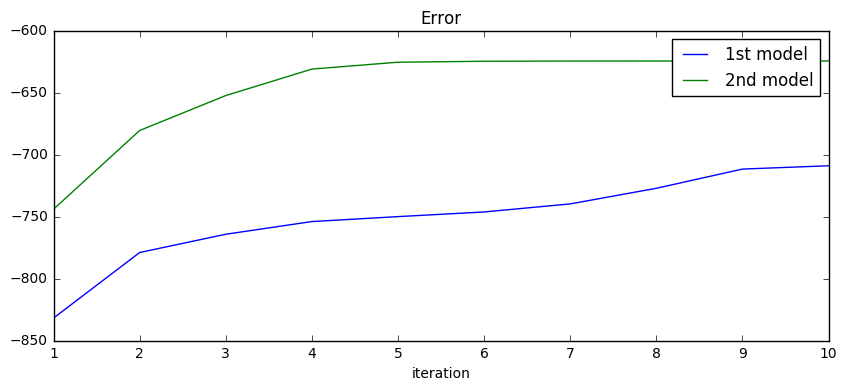

In [308]:
plt.figure(figsize=(10, 4))
plt.plot(values_1[:, 0], values_1[:, 1], label='1st model')
plt.plot(values_2[:, 0], values_2[:, 1], label='2nd model')
plt.xlabel('iteration')
plt.xlim((1, 10))
plt.title("Error")
plt.legend()
plt.show()

На графике видно, что ошибка первой модели гораздо меньше по модулю и быстрее возрастает. 

Можно сделать вывод, что, чем больше величины, генерируемые различными скрытыми состояниями, пересекаются, тем хуже будет работать данная модель предсказаний

### b) Случай двумерного гауссовского распределения

Увеличим размерность гененируемых векторов. В данном случае области наиболее вероятно генерируемых значений сделаем чуть-чуть переcекающимися по одному измерению. А вероятности перехода такими, чтобы из одного состояния мы скорее уходили, а в другом скорее оставались.

In [327]:
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. 
model.means_ = np.array([[0.0, 0.0], [1.0, -3.0]])
model.covars_ = np.array([[[2, 0], [0, 1]], [[2, 0.5], [0.5, 1]]])

Сгенерируем последовательность и нарисуем эти точки на плоскости

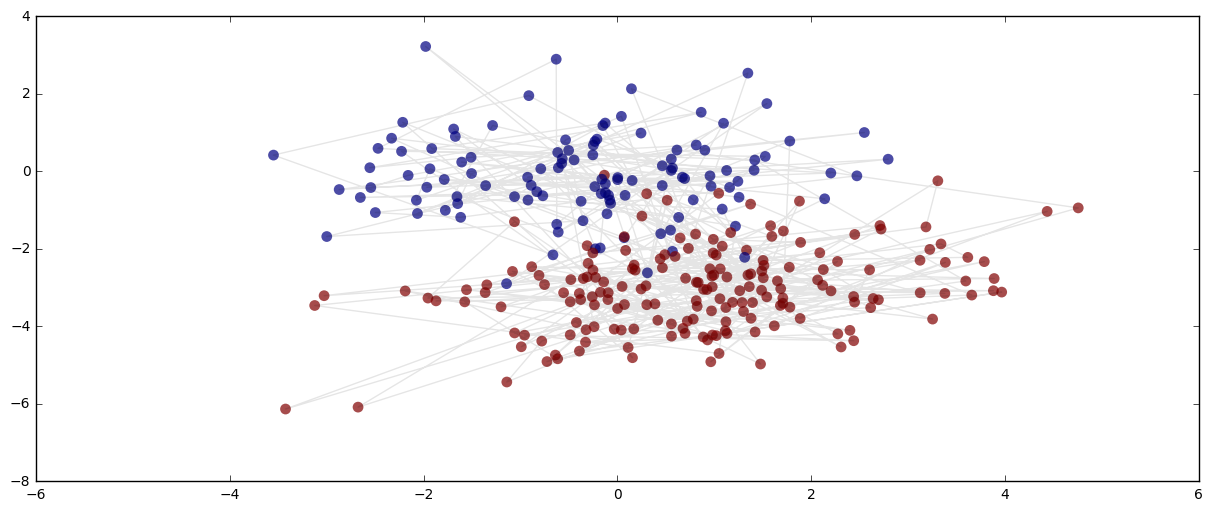

In [328]:
import warnings
warnings.filterwarnings('ignore')

size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

fig = plt.figure(figsize=(15, 6))
#plt.plot(Y[:, 0], Y[:, 1], ".-", label="observations", ms=6, mfc="orange", alpha=0.7)
plt.plot(Y[:, 0], Y[:, 1], color='black', alpha=0.1)
plt.scatter(Y[:, 0], Y[:, 1], c=np.array(X), lw=0, s=60, alpha=0.7)
#plt.xlim((0, size))
plt.show()

Итак, визуально легко предсказать по точке скрытое состояние, тк области хорошо разграничиваются

Обучение модели

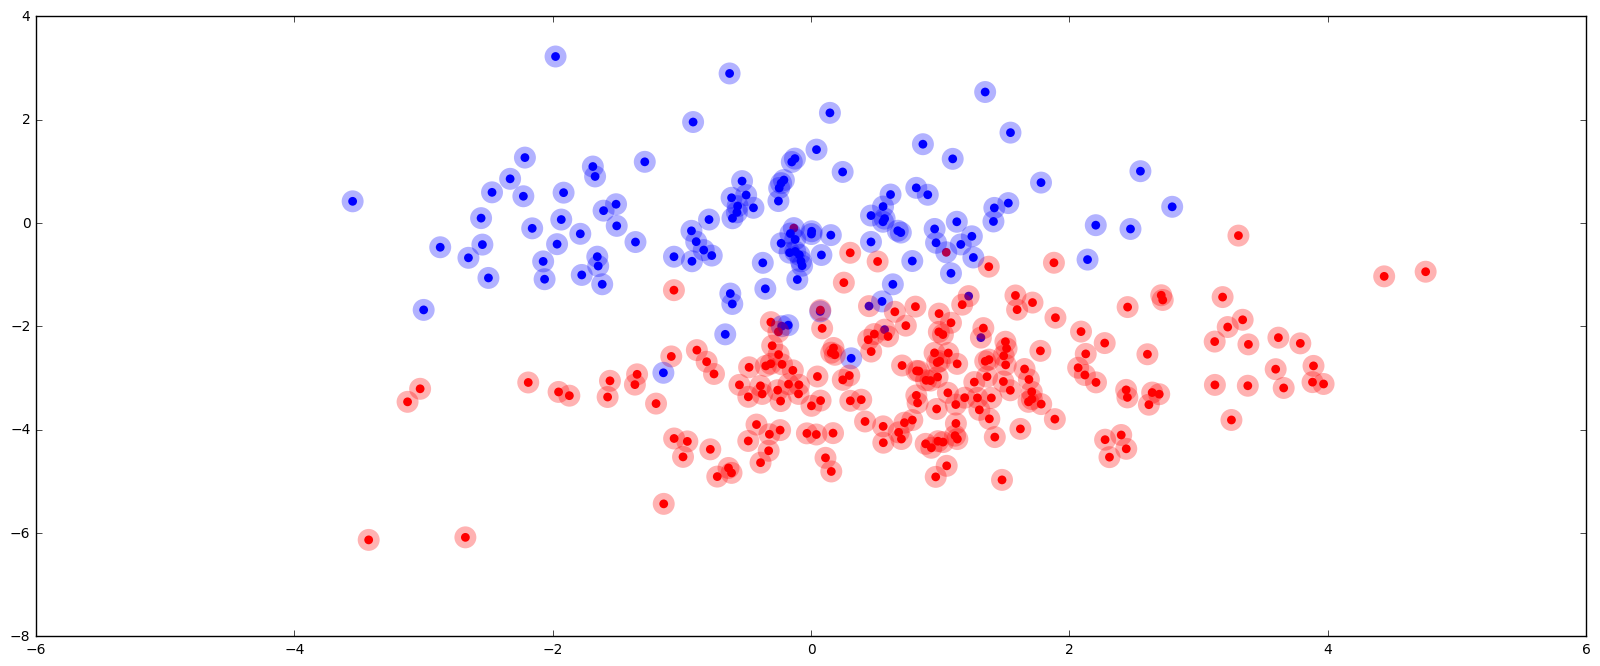

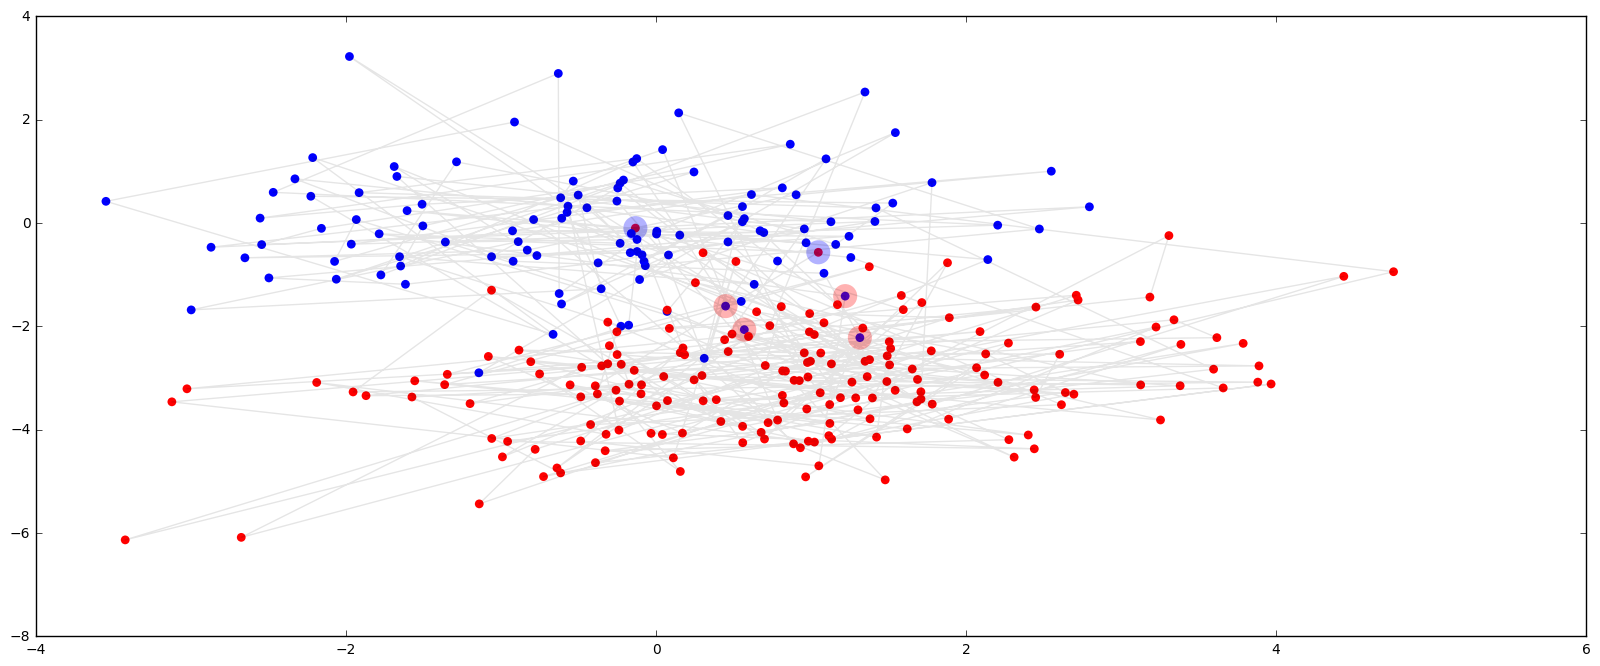

In [329]:
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')
remodel.fit(Y)  
X_predicted = remodel.predict(Y)

colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

plt.figure(figsize=(20, 8))
#plt.plot(Y[:, 0], Y[:, 1] color='black', alpha=0.1)
plt.scatter(Y[:, 0], Y[:,1], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(Y[:, 0], Y[:, 1], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(Y[:, 0], Y[:,1], color='black', alpha=0.1)
plt.scatter(Y[:, 0], Y[:,1], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(Y[:, 0][X != X_predicted], Y[:, 1][X != X_predicted],
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.show()

Итак, модель почти не ошибается

Посмотрим на разные измерения

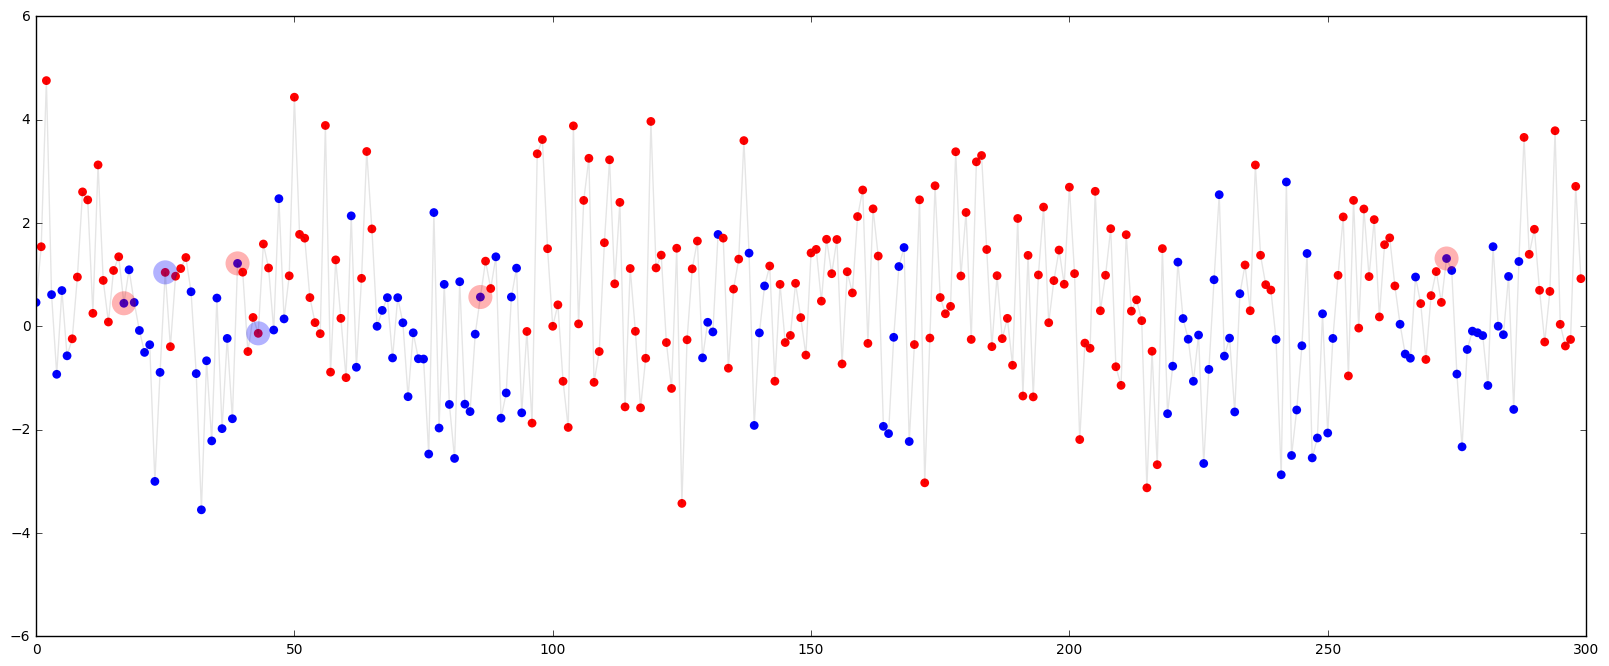

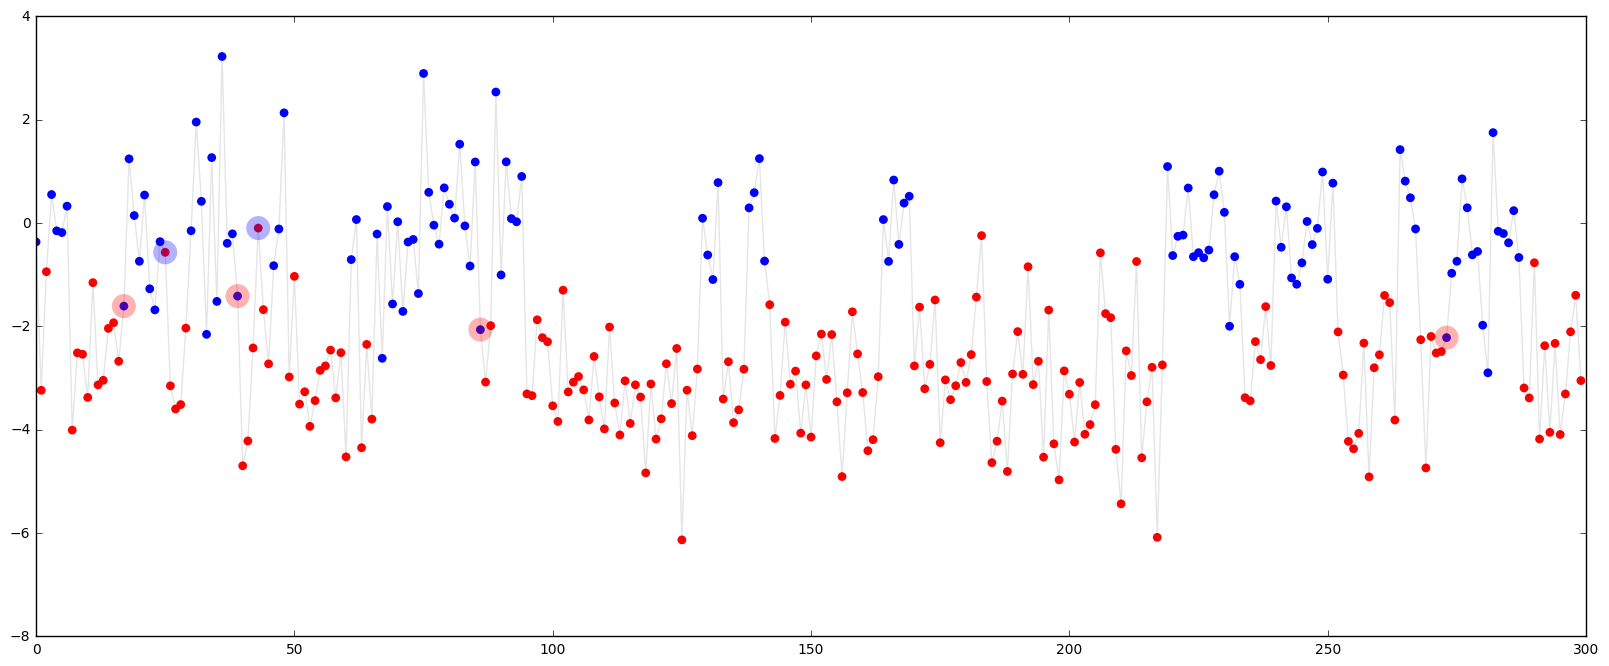

In [330]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 1], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 1], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 1][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Как и ожидалось, в первом случае состояния разграничиваются с трудом, а во втором легко. Качество классификации очень хорошее. Посмотрим на ошибку

In [331]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

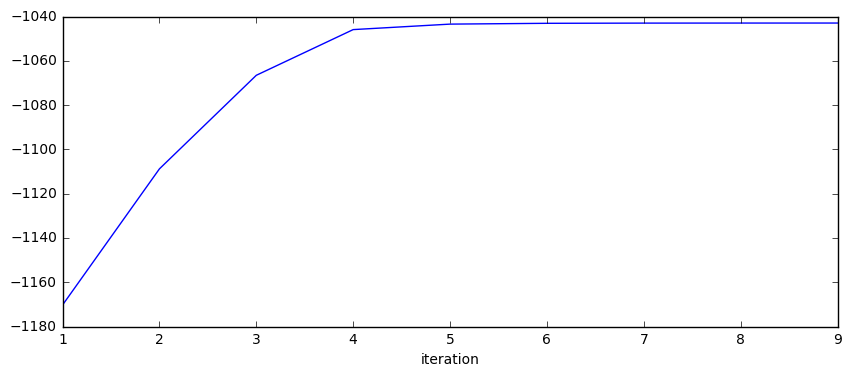

In [332]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.show()

Ошибка быстро сходится к константе, но по модулю она больше, чем раньше. Но классификатор работает очень хорошо. Из моих наблюдений получается, что большее значение имеет не модуль этого функционала, а его скорость сходимости к константе (функционалы плохох моделей сходились гораздо медленнее, чем хороших). Так же можно сделать вывод, что модель хорошо работает только на данных, которые легко разграничиваются, но в многомерном случае добавление дополнительного измерения не портит качество классификации, даже если добавленные данные сложно разделить по скрытым стостояниям сами по себе.


Кроме гауссовского случая в библиотеке реализовано два других

* `hmm.GMMHMM` --- распределение $Y_j$ при условии $X_j$ является смесью гауссовских распределений, 
* `hmm.MultinomialHMM` --- распределение $Y_j$ при условии $X_j$ является дискретным.

## 2. Картинки

<img src="./map_example.png"><img src="./map_example_target.png">

Допустим, у вас имеются спутниковые снимки, и вам нужно уметь автоматически производить их сегментацию, например, на следующие области: растительность, вода, иное. Давайте для этого разобьем изображение на прямоугольные блоки, которые будем размечать. Далее классификацию блоков можно производить независимо для каждого блока. Но в реальности между блоками есть некоторые зависимости. В частности, каждый блок сильно зависит от соседних. В качестве некоторого приближения можно предполагать между ними марковскую зависимость. Она не сможет полностью описать все зависимости, но будет лучше работать, чем если эти зависимости не учитывать вообще.

Однако марковская цепь является одномерным процессом, в то время как изображение двумерное. Чтобы применить к изображению скрытую марковскую модель, можно сделать некоторую цепочку из блоков, обходя их в некоторой последовательности. Правда, в таком случае будут потеряны еще некоторые зависимости, и сегментация будет сильно зависеть от способа обхода. Тогда можно произвести обход несколькими различными способами и результаты "объединить".

**Задания:**

(простой пример выполнения задания ниже)

1. Соберите спутниковые снимки, сделав скриншоты онлайн-карт. По каждому из них создайте примерную разметку на воду (закрасьте синим), растительность (закрасьте зеленым), остальное (закрасьте красным).

2. Каждое изображение разбейте на блоки, создав список блоков со всех снимков, используя некоторый метод обхода блоков.

3. Оцените самостоятельно все параметры скрытой марковской модели. Параметры условных плотностей можно оценить отдельно для каждого класса. Оцените также матрицу переходных вероятностей, каждый элемент которой оцените как долю переходов в одно состояние при условии того, что цепь находится в другом состоянии.

4. Загрузите новый спутниковый снимок без разметки и примените к нему полученную скрытую марковскую модель для предсказания скрытых состояний. Постройте визуальную разметку.

При желании вы можете выполнять аналогичное задание для других типов изображений, описав четко то, что вы делаете.

**Пример выполнения:**

Ниже определены некоторые вспомогательные магические функции для разрезания изображения и его обратной склейки, а так же функция для подсчета ОМП многомерного нормального распределения.

In [185]:
def cut_image(image, n, m):
    ''' Разрезает изображение на блоки размера n на m, вытягивая их в вектор'''
    
    N, M, K = image.shape  # высота, ширина, глубина (3 для RGG, 4 для RGBa)
    
              # ставим высоту последним измерением и разбиваем по нему
    X = image.transpose((1, 2, 0)).reshape((M, K, N / n, n)) .transpose((1, 2, 3, 0)).reshape((K, N / n, n, M / m, m)).transpose((1, 3, 2, 4, 0)).reshape((N * M / (n * m), n * m * K))
            # ставим ширину последним разбиением и разбиваем по нему
            # на первое место ставим два измерения, соответствующие блокам
            # объединяем блоковые размерности и все остальные
            
    return X


def recat_image(X, N, M, K, n, m):
    ''' Собирает разрезанное ранее изображение из блоков n на m'''
    
    # Тут такая же магия
    return X.reshape((N / n, M / m, n, m, K)).transpose((1, 3, 4, 0, 2)) \
             .reshape((M / m, m, K, N)).transpose((3, 2, 0, 1)) \
             .reshape((N, K, M)).transpose((0, 2, 1))


def est_gauss(X):
    ''' Оценка параметров многомерного гауссовского распределения с помощью ОМП
    '''
    
    mean = X.mean(axis=0)
    X_centered = np.matrix(X - mean[np.newaxis, :])
    cov_matrix = np.array(X_centered.T * X_centered / X.shape[0])
    return mean, cov_matrix

Загрузим карту и разметку (только одну, а вам нужно много снимков и разными способами обхода)

In [186]:
image = plt.imread('map.png')
image = image[:350, :625, :]  # обрезка краев, для целочисленного деления
Y = cut_image(image, 25, 25)   # при разбиении на блоки

target = plt.imread('map_target.png')
target = target[:350, :625, :]
target = cut_image(target, 25, 25)
X = (target.sum(axis=1) > target.shape[1] / 2).astype(int)  # бинаризация меток

Оценим все параметры и зададим скрытую марковскую модель

In [207]:
means, covars = [0, 0], [0, 0]
means[0], covars[0] = est_gauss(Y[X == 0])
means[1], covars[1] = est_gauss(Y[X == 1])
means = np.array(means)
covars = np.array(covars)
covars[0] = covars[0] + 0.01*np.eye(covars.shape[1])
covars[1] = covars[1] + 0.01*np.eye(covars.shape[1])
transmat = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        transmat[i, j] = 0.5

model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.startprob_ = np.array([0.5, 0.5])
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

Загружаем тестовое изображение и разбиваем его на блоки

In [208]:
test_image = plt.imread('map_test_1.png')
test_image = test_image[:375, :625, :]
test_Y = cut_image(test_image, 25, 25)

Оценим для него значения скрытых состояний и создадим необходимый фон.

In [209]:
# Оценка значений скрытых состояний
# Может вылететь исключение о вырожденной матрице ковариаций.
# В таком случае можно матрицу регуляризовать --- добавить к диагональным
# элементам небольное число так, чтобы детерминант перестал быть слишком маленьким
predicted = model.predict(test_Y)

print(test_Y.shape)

# Создаем фоновую картинку того же размера
newimg = np.zeros((375, 625, 3))
newimg[:,:, 2] += predicted[:, np.newaxis]
background = recat_image(newimg, 375, 625, 3, 25, 25)

# Добавляем к ней 4-й альфа-канал, который отвечает за прозрачность
background_alpha = np.zeros((background.shape[0], background.shape[1], 4))
# RGB копируем, сейчас там либо 000, либо 111
background_alpha[:, :, :3] = background
# полупрозрачность
background_alpha[:, :, 3] = 0.5
# зеленая компонента обратно красной
background_alpha[:, :, 1] = 1 - background_alpha[:, :, 1]
# синию зануляем полностью
background_alpha[:, :, 2] = 0

(375, 2500)


Теперь можно изобразить исходную картинку и ее же с наложением фона

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(test_image)
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(test_image)
plt.imshow(background_alpha)
plt.axis('off')
plt.show()

Вспомним, что оценка траекторий определяется с помощью максимизации апостериорных вероятностей. Поэтому вместо строгой классификации можно использовать нестрогую --- относить каждый блок к каждому классу с некоторой вероятностью. По таким вероятностям можно сделать соответствующий фон для изображения. Сделайте это.

In [ ]:
# Оценка вероятностей
predicted_proba = model.predict_proba(test_Y)

<Определение background_alpha>
<Картинки>

## Музыка

В отличие от изображений, в музыкальных треках есть четкая компонента времени.

Некоторый вспомогательный код.

In [31]:
import librosa
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}'" +
                        "type=\"audio/wav\"></audio>".format(url))

Загрузите сюда некоторый музыкальный трек (или свой голос). Тут же вы его можете послушать. Да, теперь можно выполнять задание, и тут же в питон-ноутбуке слушать музыку. До чего техника дошла!

In [42]:
sound_file = "https://cs1-51v4.vk-cdn.net/p20/dd7164c83c3cb2.mp3?extra=p6WoF9b_Kn3nxz9aUEMJ6ckPIjSHiUoYvZsfKfmuVDRmpph477CvcokpNvL776P_4yslVzxN2QI_npdMFKJv7R1t5uhtKdsiJQc8Ot7458yjXnVrUDxNwr0AHklmUUjI-79CcLAmQQ&no_cover=1"
Audio(url=sound_file)

Изобразим графики амплитуды для разной sampling rate (sr).

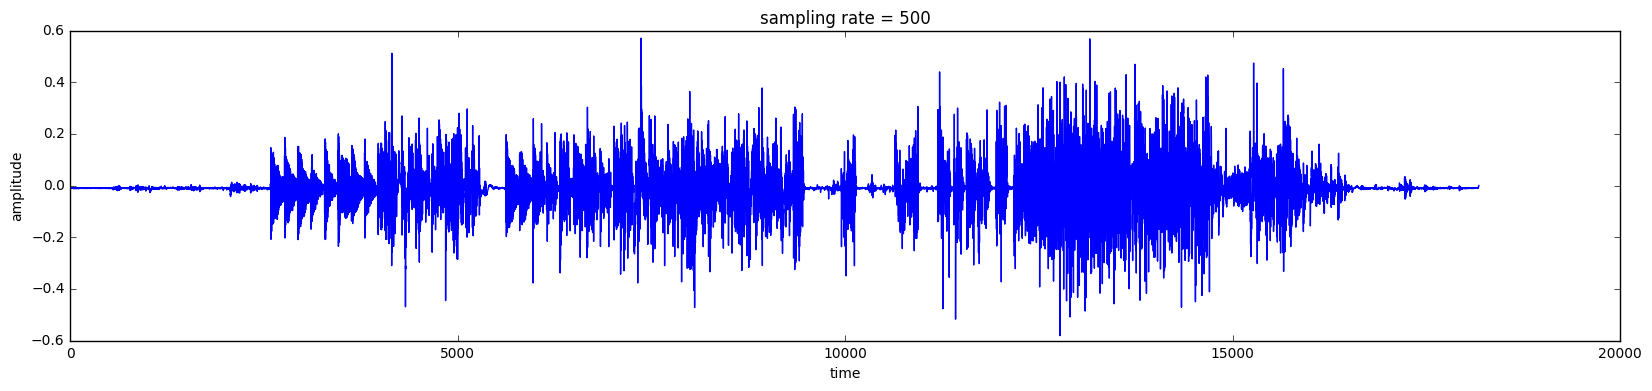

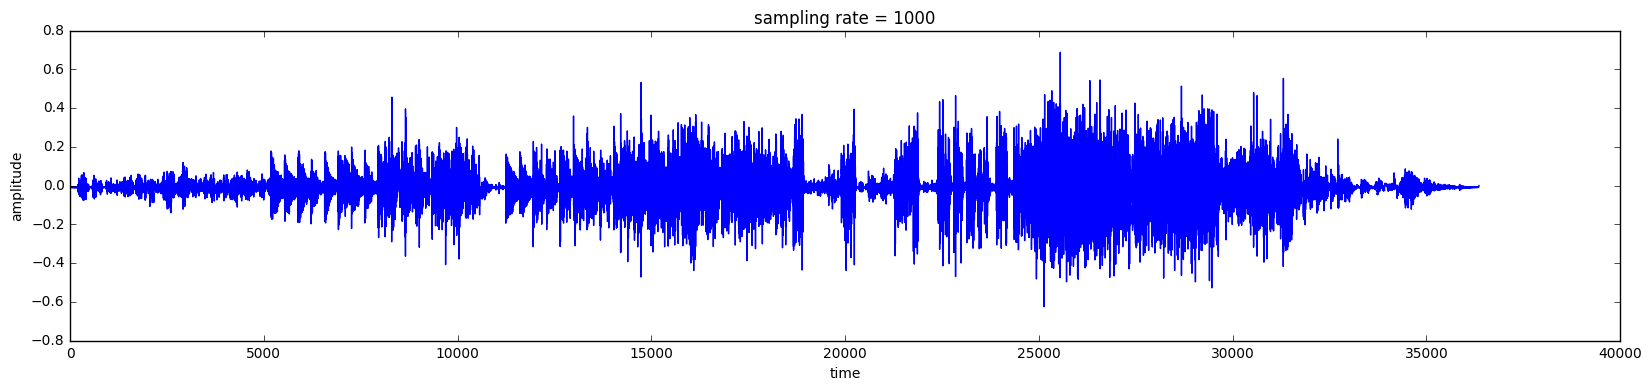

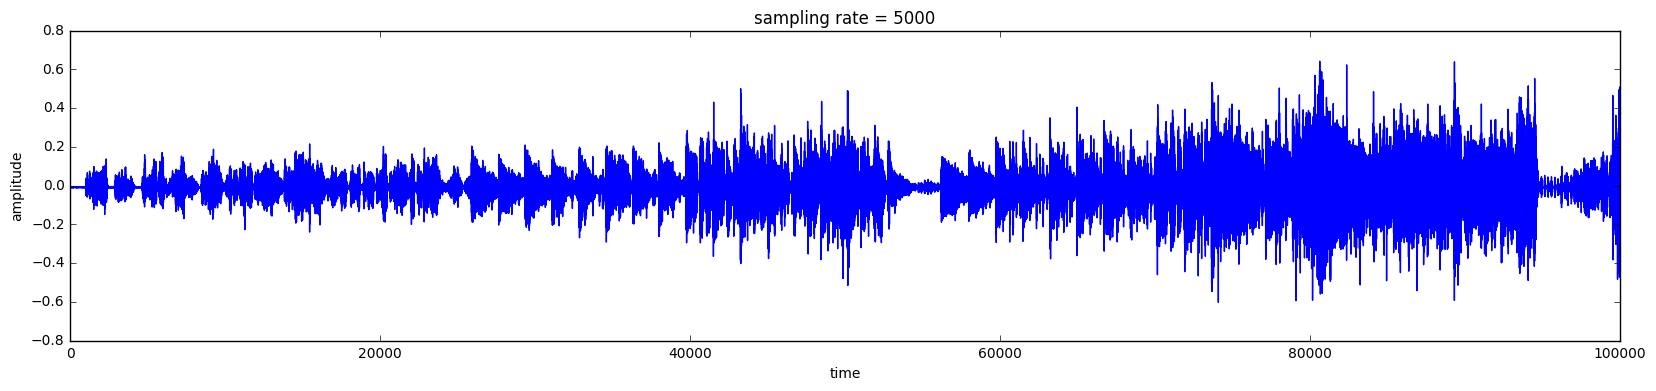

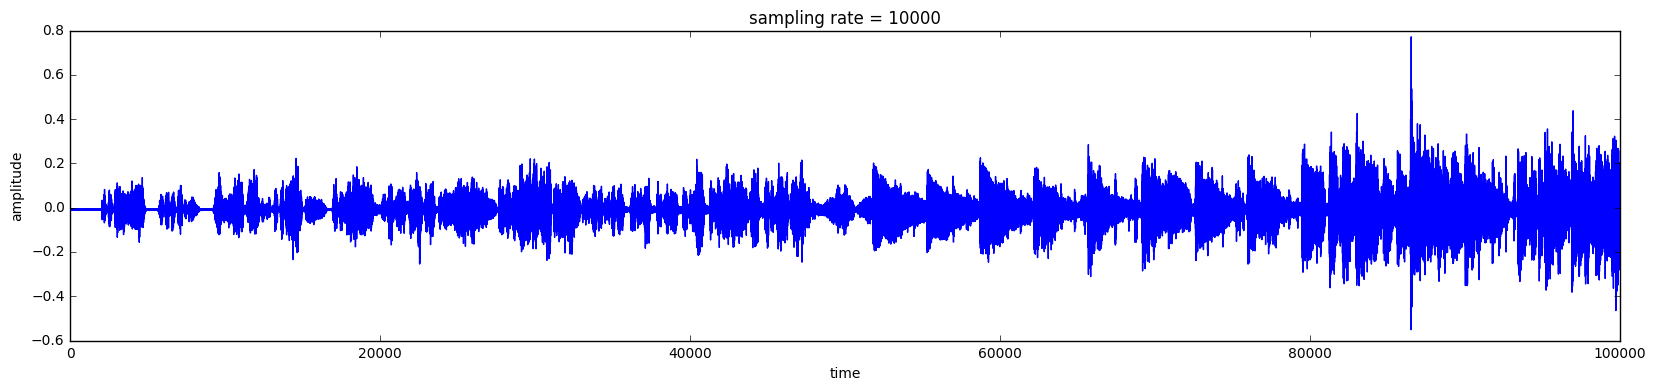

In [39]:
for sr in [500, 1000, 5000, 10000]:
    plt.figure(figsize=(20, 4))
    y, sr = librosa.load(sound_file, sr=sr)
    plt.plot(y[:1000000:10])
    plt.ylabel("amplitude")
    plt.xlabel("time")
    plt.title('sampling rate = {}'.format(sr))
    plt.show()

Изобразим спектрограмму

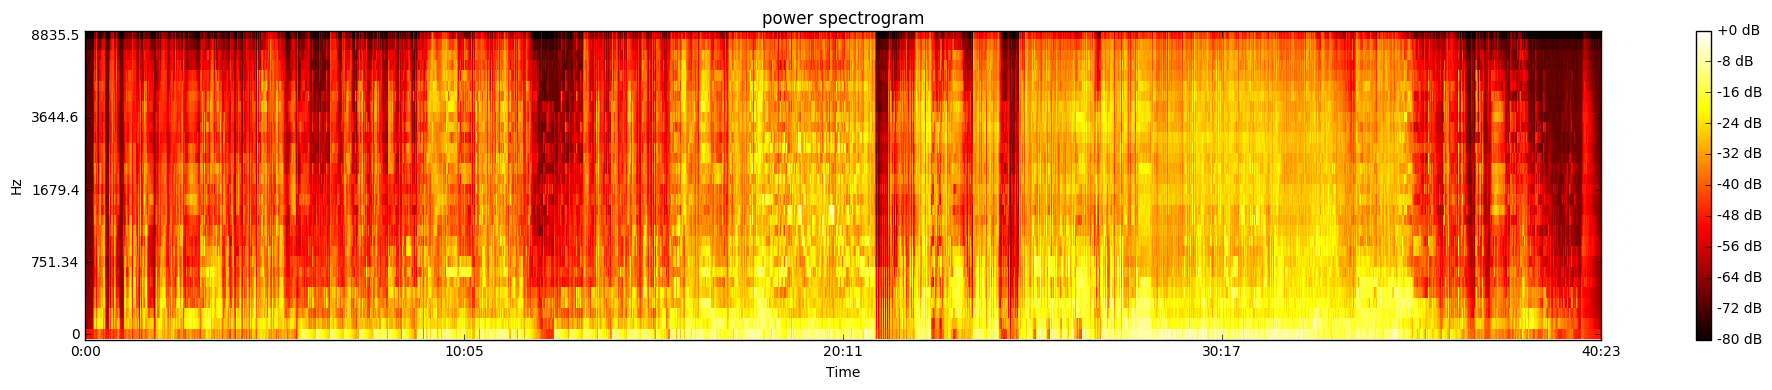

In [40]:
sr = 1500

# Если ваш ноутбук не справляется с чем-то, уменьшите параметр n_mels
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=30)
log_S = librosa.logamplitude(S, ref_power=np.max)

plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', 
                         y_axis='mel', cmap='hot')
plt.title('power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

Если выполнить операцию транспонирования, то мы получим некоторый многомерный случайный процесс. К нему уже можно применить скрытую марковскую модель.

In [41]:
Y = log_S.T

По данным наблюдениям оцените параметры скрытой марковской модели (см. примеры выше). За сколько итераций сошелся EM-алгоритм? Оцените значения скрытых состояний. На какие по смыслу состояния модель разделила ваш трек? Возможно, для этого придется еще раз послушать трек. Примените эту модель так же к другим трекам. Сделайте выводы.

**Баллы за задание:**

- **2 балла** за первую часть.
- по **5 баллов** максимум за вторую и третью части. Максимум ставится только при наличии интересных результатов.